In [33]:
import pandas as pd 
import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
metadata = pd.read_csv("../Project-Disney-World-DSF/metadata.csv")
hauntedhouse = pd.read_csv("../Project-Disney-World-DSF/haunted_mansion[87].csv")

metadata.shape

(2079, 181)

**Preparing Hounted House Data**

In [3]:
#compute percentage of na-values per column; result: 96.59% of actual waiting times are na
hauntedhouse.isna().mean()

#extract and drop SACTMIN column from Df
act_times = hauntedhouse.copy()["SACTMIN"]
hauntedhouse = hauntedhouse.drop(["SACTMIN"], axis=1)
hauntedhouse

,date,datetime,SPOSTMIN
0,01/01/2015,2015-01-01 08:23:09,-999.0
1,01/01/2015,2015-01-01 08:37:13,10.0
2,01/01/2015,2015-01-01 08:37:31,-999.0
3,01/01/2015,2015-01-01 08:44:11,10.0
4,01/01/2015,2015-01-01 08:51:12,10.0
...,...,...,...
319951,12/28/2021,2021-12-28 22:36:08,13.0
319952,12/28/2021,2021-12-28 22:42:15,13.0
319953,12/28/2021,2021-12-28 22:48:12,13.0
319954,12/28/2021,2021-12-28 22:54:10,13.0


In [4]:
#format column date
hauntedhouse['date'] = pd.to_datetime(hauntedhouse['date'])
#format column datetime
hauntedhouse['datetime'] = pd.to_datetime(hauntedhouse['datetime'])


In [5]:
#drop rows with missing waiting times (coded as -999); dataset does NOT include observations during covid-19 closure time in the first place
hauntedhouse.loc[hauntedhouse['SPOSTMIN'] == -999,'SPOSTMIN'] = np.nan
hauntedhouse = hauntedhouse.dropna(axis=0, subset="SPOSTMIN")
hauntedhouse = hauntedhouse.reset_index(drop=True)          
hauntedhouse

,date,datetime,SPOSTMIN
0,2015-01-01,2015-01-01 08:37:13,10.0
1,2015-01-01,2015-01-01 08:44:11,10.0
2,2015-01-01,2015-01-01 08:51:12,10.0
3,2015-01-01,2015-01-01 09:02:13,15.0
4,2015-01-01,2015-01-01 09:09:16,20.0
...,...,...,...
293282,2021-12-28,2021-12-28 22:36:08,13.0
293283,2021-12-28,2021-12-28 22:42:15,13.0
293284,2021-12-28,2021-12-28 22:48:12,13.0
293285,2021-12-28,2021-12-28 22:54:10,13.0


/var/folders/x1/vdcy4hm5621f8lv9m63lj8m40000gn/T/ipykernel_19992/1913996283.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  summer_day = hauntedhouse.loc[hauntedhouse["date"]=='17/01/2021'] #sunday


Text(0.5, 0, 'Time')

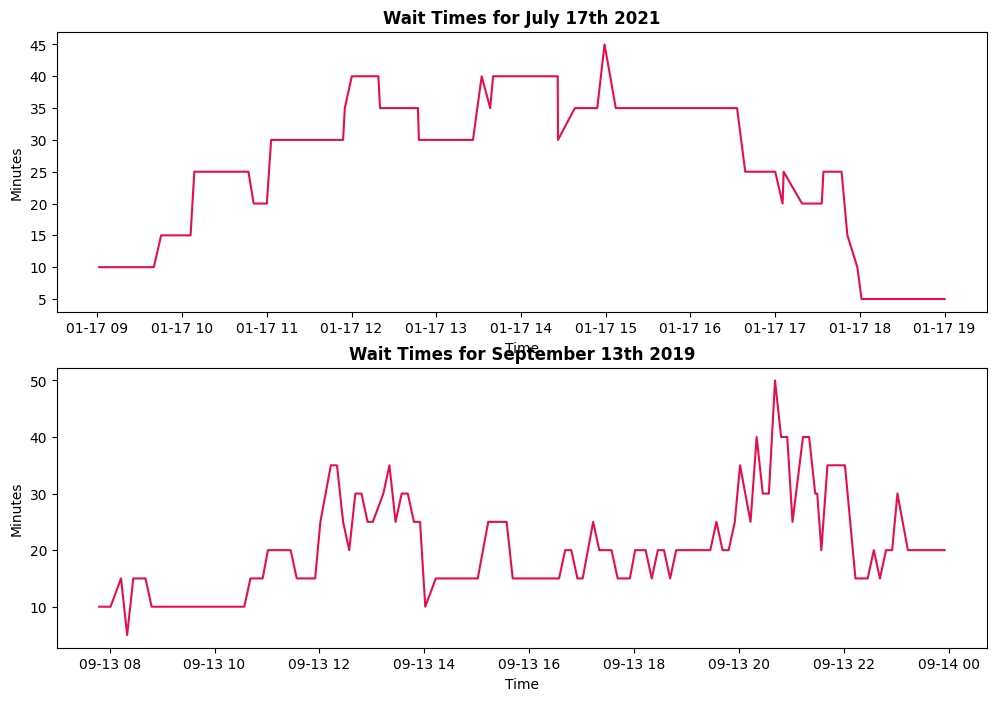

In [6]:
#Wochentag
summer_day = hauntedhouse.loc[hauntedhouse["date"]=='17/01/2021'] #sunday
winter_day = hauntedhouse.loc[hauntedhouse["date"]=='09/13/2019'] #Montag

fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(summer_day["datetime"], summer_day["SPOSTMIN"], color='#e60e4b')
axs[0].set_title("Wait Times for July 17th 2021", weight='bold')
axs[0].set_ylabel("Minutes")
axs[0].set_xlabel("Time")

axs[1].plot(winter_day["datetime"], winter_day["SPOSTMIN"], color='#e60e4b')
axs[1].set_title("Wait Times for September 13th 2019", weight='bold')
axs[1].set_ylabel("Minutes")
axs[1].set_xlabel("Time")




**Preparing Metadata**

In [7]:
#looking at percentage of na-values per column
metadata.isna().mean().sort_values(ascending=False).head(20)

AKFIREN      1.000000
AKPRDDN      1.000000
AKPRDDT2     1.000000
AKPRDDT1     1.000000
HSPRDDN      1.000000
HSPRDDT1     1.000000
EPFIRET2     0.997595
MKFIRET2     0.995190
HSFIRET2     0.983646
HOLIDAYJ     0.979798
AKeventN     0.966811
WDWRaceN     0.958153
HSeventN     0.902838
HOLIDAYN     0.897066
MKPRDDT2     0.890332
WDWeventN    0.881193
MKeventN     0.743627
MKPRDNT2     0.711881
HSSHWNT2     0.658490
MKPRDNN      0.653199
dtype: float64

In [8]:
#remove variables related to Hollywood Studios Park in California (and not Walt Disney World in Florida)
metadata.columns.str.startswith('HS').sum() 
metadata.columns.str.endswith('_HS').sum() 

metadata = metadata.loc[:, ~metadata.columns.str.startswith('HS')]
metadata = metadata.loc[:, ~metadata.columns.str.endswith('_HS')]

metadata.shape

(2079, 145)

In [9]:
#filter out columns with all na-values
metadata.dropna(axis=1, how='all', inplace=True)

#format date
metadata['DATE'] = pd.to_datetime(metadata['DATE'])

metadata.shape

(2079, 141)

In [10]:
#function that deals with string percentage values for columns that contain percentage of schools in session
def str_percent_to_float(dataframe):
    for col in dataframe.columns:
        if col.lower().startswith('insession'):
            dataframe[col] = dataframe[col].str.rstrip("%").astype(float)/100
            
str_percent_to_float(metadata)
metadata

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,...,MKFIREN,EPFIREWK,EPFIRET1,EPFIRET2,EPFIREN,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,2015-01-01,NaN,5,0,0,1,2015,CHRISTMAS PEAK,0,5,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
1,2015-01-02,NaN,6,1,0,1,2015,CHRISTMAS,2,5,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
2,2015-01-03,NaN,7,2,0,1,2015,CHRISTMAS,3,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
3,2015-01-04,NaN,1,3,1,1,2015,CHRISTMAS,4,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
4,2015-01-05,NaN,2,4,1,1,2015,CHRISTMAS,5,0,...,Wishes Nighttime Spectacular,1,21:00,NaN,IllumiNations: Reflections of Earth,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2074,2021-08-27,NaN,6,238,34,8,2021,NaN,11,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2075,2021-08-28,NaN,7,239,34,8,2021,NaN,10,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2076,2021-08-29,NaN,1,240,35,8,2021,NaN,9,0,...,Happily Ever After,1,22:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN
2077,2021-08-30,NaN,2,241,35,8,2021,NaN,8,0,...,Happily Ever After,1,21:00,NaN,Epcot Forever,0,0,NaN,NaN,NaN


In [11]:
#function that deals with string times of form '9:00' or '25:00'; converts to hours since midnight (float) for consistency and usability
sww = ["MKOPEN", "MKCLOSE", "MKEMHOPEN", "MKEMHCLOSE", "MKOPENYEST", "MKCLOSEYEST", "MKOPENTOM", "MKCLOSETOM", "EPOPEN", "EPCLOSE", "EPEMHOPEN",
"EPEMHCLOSE", "EPOPENYEST", "EPCLOSEYEST", "EPOPENTOM", "EPCLOSETOM", "AKOPEN", "AKCLOSE", "AKEMHOPEN", "AKEMHCLOSE", "AKOPENYEST", "AKCLOSEYEST",
"AKOPENTOM", "AKCLOSETOM", "MKPRDDT1", "MKPRDDT2", "MKPRDNT1", "MKPRDNT2", "MKFIRET1", "MKFIRET2", "EPFIRET1", "EPFIRET2", "AKSHWNT1", "AKSHWNT2"]

for col in sww:
    metadata[col].fillna("99", inplace=True)  #to indicate outliers

metadata["MKCLOSE"][0]

'25:00'

In [12]:
def format_times(x):
    if len(x)==4:
        time = '0'+ x
    elif len(x)==5 and x > '24:00':
        hour = int(x[:2])-24
        minute = x[-2:]
        time = '0' + str(hour) + ':' + minute
    elif x == '24:00':
        time = '00:00'
    else:
        time = x
    return time

def str_times_to_numerical(dataframe):
    for col in sww:
        dataframe[col] = dataframe[col].apply(format_times)
        dataframe[col] = dataframe[col].apply(lambda y: y.rstrip(':'))
        dataframe[col] = dataframe[col].apply(lambda x: (float(x[:2])+(float(x[-2:])/60)) if x[0] != 0 else (float(x[1])+(float(x[-2:])/60)))

str_times_to_numerical(metadata)


In [13]:
#one-hot encoding of categorical features
categorical_features = ["WDW_TICKET_SEASON", "SEASON", "HOLIDAYN", "WDWTICKETSEASON", "WDWRaceN", "WDWeventN", "WDWSEASON", "MKeventN", "EPeventN", "AKeventN", "HOLIDAYJ", "MKPRDDN", "MKPRDNN", "MKFIREN", "EPFIREN", "AKSHWNN"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_features),
    remainder='passthrough')

transformed = transformer.fit_transform(metadata)
encoded_metadata = pd.DataFrame(transformed, columns=transformer.get_feature_names())
#new name of columns for i encoded column: 'onehotencoder__xi_oldcategoryname'

encoded_metadata.shape


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(2079, 277)

In [14]:
#function for filling missing values, to be used at later time
def imputation(dataframe):
        for col in dataframe.columns:
                dataframe[col] = dataframe[col].fillna(method='bfill')
                dataframe[col] = dataframe[col].fillna(dataframe[col].median())
        return dataframe

Merge datasets

In [15]:
#change name of "DATE" column in metadata to fit with Haunted House 
encoded_metadata.rename(columns={"DATE":"date"}, inplace=True)

In [16]:
#merge metadata and waiting time data 
waittimes = pd.merge(hauntedhouse, encoded_metadata, how='left', on='date')

In [17]:
#Formatting of dates and times 
#drop date column due to redundancy
waittimes = waittimes.loc[:, waittimes.columns != "date"]

#create two new variables for hour and minute (day, month and year already included)
waittimes["HOUROFDAY"] = waittimes.copy()['datetime'].dt.hour
waittimes["MINUTEOFHOUR"] = waittimes.copy()['datetime'].dt.minute
#then drop datetime column
waittimes = waittimes.loc[:, waittimes.columns != 'datetime']


In [18]:
#subset for years 2019-2021 due to computing constraints
waittimes = waittimes.loc[waittimes["YEAR"].isin(range(2019,2022))].reset_index(drop=True)
waittimes

,SPOSTMIN,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,onehotencoder__x1_CHRISTMAS PEAK,onehotencoder__x1_COLUMBUS DAY,onehotencoder__x1_EASTER,onehotencoder__x1_FALL,...,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2,HOUROFDAY,MINUTEOFHOUR
0,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,2,18.5,20.0,9,7
1,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,2,18.5,20.0,9,11
2,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,2,18.5,20.0,9,14
3,15.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,2,18.5,20.0,9,21
4,10.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,2,18.5,20.0,9,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70814,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,0,100.65,100.65,20,33
70815,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,0,100.65,100.65,20,40
70816,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,0,100.65,100.65,20,47
70817,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,100.65,1,21.0,100.65,0,0,100.65,100.65,20,54


In [20]:
# loop to remove outliers x times
x = 4
n = 1
while n <= x:
    nr_arr = waittimes["SPOSTMIN"].to_numpy()
    indices = []
    for index in range(1,len(nr_arr)):
        if (nr_arr[index] - nr_arr[index-1]) > (waittimes["SPOSTMIN"].std() * 2):
            indices.append(index)
    waittimes = waittimes.drop((indices), axis=0)
    n += 1

waittimes.shape

(70700, 279)

Exponential Smoothing attempt

In [29]:
subset_exp = waittimes[waittimes.columns[~waittimes.columns.isin(["SPOSTMIN", "YEAR", "HOUROFDAY", "MINUTEOFHOUR", "DAYOFWEEK", "DAYOFYEAR", "WEEKOFYEAR", "MONTHOFYEAR"])]]
subset_exp

,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,onehotencoder__x1_CHRISTMAS PEAK,onehotencoder__x1_COLUMBUS DAY,onehotencoder__x1_EASTER,onehotencoder__x1_FALL,onehotencoder__x1_HALLOWEEN,...,MKFIREWK,MKFIRET1,MKFIRET2,EPFIREWK,EPFIRET1,EPFIRET2,AKPRDDAY,AKSHWNGT,AKSHWNT1,AKSHWNT2
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,18.5,20.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,18.5,20.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,18.5,20.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,18.5,20.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,20.0,100.65,1,21.0,100.65,0,2,18.5,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20.75,100.65,1,21.0,100.65,0,0,100.65,100.65
70815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20.75,100.65,1,21.0,100.65,0,0,100.65,100.65
70816,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20.75,100.65,1,21.0,100.65,0,0,100.65,100.65
70817,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,20.75,100.65,1,21.0,100.65,0,0,100.65,100.65


In [50]:
subset_50 = waittimes["AKSHWNGT"]
subset_50

0        2
1        2
2        2
3        2
4        2
        ..
70814    0
70815    0
70816    0
70817    0
70818    0
Name: AKSHWNGT, Length: 70700, dtype: object

In [52]:
# function for exponential smoothing
def exponential_smoothing(X,α):
	S = np.zeros(X.shape[0])
	S[0] = X[0]
	for t in range(1,X.shape[0]):
		S[t] = α * X[t-1] + (1- α) * S[t-1]
	return S

In [54]:
exponential_smoothing(subset_exp, 0.2)

KeyError: 0

In [48]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose


In [39]:
fit3 = SimpleExpSmoothing(subset_50, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3)



ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereonehotencoder__x0_peak         object
onehotencoder__x0_regular      object
onehotencoder__x0_value        object
onehotencoder__x0_nan          object
onehotencoder__x1_CHRISTMAS    object
                                ...  
EPFIRET2                       object
AKPRDDAY                       object
AKSHWNGT                       object
AKSHWNT1                       object
AKSHWNT2                       object
Length: 271, dtype: object and None. The data was
   onehotencoder__x0_peak onehotencoder__x0_regular onehotencoder__x0_value  \
0                     1.0                       0.0                     0.0   
1                     1.0                       0.0                     0.0   
2                     1.0                       0.0                     0.0   
3                     1.0                       0.0                     0.0   
4                     1.0                       0.0                     0.0   
5                     1.0                       0.0                     0.0   
6                     1.0                       0.0                     0.0   
7                     1.0                       0.0                     0.0   
8                     1.0                       0.0                     0.0   
9                     1.0                       0.0                     0.0   
10                    1.0                       0.0                     0.0   
11                    1.0                       0.0                     0.0   
12                    1.0                       0.0                     0.0   
13                    1.0                       0.0                     0.0   
14                    1.0                       0.0                     0.0   
15                    1.0                       0.0                     0.0   
16                    1.0                       0.0                     0.0   
17                    1.0                       0.0                     0.0   
18                    1.0                       0.0                     0.0   
19                    1.0                       0.0                     0.0   
20                    1.0                       0.0                     0.0   
21                    1.0                       0.0                     0.0   
22                    1.0                       0.0                     0.0   
23                    1.0                       0.0                     0.0   
24                    1.0                       0.0                     0.0   
25                    1.0                       0.0                     0.0   
26                    1.0                       0.0                     0.0   
27                    1.0                       0.0                     0.0   
28                    1.0                       0.0                     0.0   
29                    1.0                       0.0                     0.0   
30                    1.0                       0.0                     0.0   
31                    1.0                       0.0                     0.0   
32                    1.0                       0.0                     0.0   
33                    1.0                       0.0                     0.0   
34                    1.0                       0.0                     0.0   
35                    1.0                       0.0                     0.0   
36                    1.0                       0.0                     0.0   
37                    1.0                       0.0                     0.0   
38                    1.0                       0.0                     0.0   
39                    1.0                       0.0                     0.0   
40                    1.0                       0.0                     0.0   
41                    1.0                       0.0                     0.0   
42                    1.0                       0.0                     0.0   
43                    1.0                       0.0                     0.0   
44                    1.0                       0.0                     0.0   
45                    1.0                       0.0                     0.0   
46                    1.0                       0.0                     0.0   
47                    1.0                       0.0                     0.0   
48                    1.0                       0.0                     0.0   
49                    1.0                       0.0                     0.0   

   onehotencoder__x0_nan onehotencoder__x1_CHRISTMAS  \
0                    0.0                         0.0   
1                    0.0                         0.0   
2                    0.0                         0.0   
3                    0.0                         0.0   
4                    0.0                         0.0   
5                    0.0                         0.0   
6                    0.0                         0.0   
7                    0.0                         0.0   
8                    0.0                         0.0   
9                    0.0                         0.0   
10                   0.0                         0.0   
11                   0.0                         0.0   
12                   0.0                         0.0   
13                   0.0                         0.0   
14                   0.0                         0.0   
15                   0.0                         0.0   
16                   0.0                         0.0   
17                   0.0                         0.0   
18                   0.0                         0.0   
19                   0.0                         0.0   
20                   0.0                         0.0   
21                   0.0                         0.0   
22                   0.0                         0.0   
23                   0.0                         0.0   
24                   0.0                         0.0   
25                   0.0                         0.0   
26                   0.0                         0.0   
27                   0.0                         0.0   
28                   0.0                         0.0   
29                   0.0                         0.0   
30                   0.0                         0.0   
31                   0.0                         0.0   
32                   0.0                         0.0   
33                   0.0                         0.0   
34                   0.0                         0.0   
35                   0.0                         0.0   
36                   0.0                         0.0   
37                   0.0                         0.0   
38                   0.0                         0.0   
39                   0.0                         0.0   
40                   0.0                         0.0   
41                   0.0                         0.0   
42                   0.0                         0.0   
43                   0.0                         0.0   
44                   0.0                         0.0   
45                   0.0                         0.0   
46                   0.0                         0.0   
47                   0.0                         0.0   
48                   0.0                         0.0   
49                   0.0                         0.0   

   onehotencoder__x1_CHRISTMAS PEAK onehotencoder__x1_COLUMBUS DAY  \
0                               1.0                            0.0   
1                               1.0                            0.0   
2                               1.0                            0.0   
3                               1.0                            0.0   
4                               1.0                            0.0   
5                               1.0                            0.0   
6                               1.0                            0.0   
7                               1.0                            0.0   
8                               1.0                            0.0   
9                               1.0                            0.0   
10                              1.0                            0.0   
11                              1.0                            0.0   
12                              1.0                            0.0   
13                              1.0                            0.0   
14                              1.0                            0.0   
15                              1.0                            0.0   
16                              1.0                            0.0   
17                              1.0                            0.0   
18                              1.0                            0.0   
19                              1.0                            0.0   
20                              1.0                            0.0   
21                              1.0                            0.0   
22                              1.0                            0.0   
23                              1.0                            0.0   
24                              1.0                            0.0   
25                              1.0                            0.0   
26                              1.0                            0.0   
27                              1.0                            0.0   
28                              1.0                            0.0   
29                              1.0                            0.0   
30                              1.0                            0.0   
31                              1.0                            0.0   
32                              1.0                            0.0   
33                              1.0                            0.0   
34                              1.0                            0.0   
35                              1.0                            0.0   
36                              1.0                            0.0   
37                              1.0                            0.0   
38                              1.0                            0.0   
39                              1.0                            0.0   
40                              1.0                            0.0   
41                              1.0                            0.0   
42                              1.0                            0.0   
43                              1.0                            0.0   
44                              1.0                            0.0   
45                              1.0                            0.0   
46                              1.0                            0.0   
47                              1.0                            0.0   
48                              1.0                            0.0   
49                              1.0                            0.0   

   onehotencoder__x1_EASTER onehotencoder__x1_FALL  \
0                       0.0                    0.0   
1                       0.0                    0.0   
2                       0.0                    0.0   
3                       0.0                    0.0   
4                       0.0                    0.0   
5                       0.0                    0.0   
6                       0.0                    0.0   
7                       0.0                    0.0   
8                       0.0                    0.0   
9                       0.0                    0.0   
10                      0.0                    0.0   
11                      0.0                    0.0   
12                      0.0                    0.0   
13                      0.0                    0.0   
14                      0.0                    0.0   
15                      0.0                    0.0   
16                      0.0                    0.0   
17                      0.0                    0.0   
18                      0.0                    0.0   
19                      0.0                    0.0   
20                      0.0                    0.0   
21                      0.0                    0.0   
22                      0.0                    0.0   
23                      0.0                    0.0   
24                      0.0                    0.0   
25                      0.0                    0.0   
26                      0.0                    0.0   
27                      0.0                    0.0   
28                      0.0                    0.0   
29                      0.0                    0.0   
30                      0.0                    0.0   
31                      0.0                    0.0   
32                      0.0                    0.0   
33                      0.0                    0.0   
34                      0.0                    0.0   
35                      0.0                    0.0   
36                      0.0                    0.0   
37                      0.0                    0.0   
38                      0.0                    0.0   
39                      0.0                    0.0   
40                      0.0                    0.0   
41                      0.0                    0.0   
42                      0.0                    0.0   
43                      0.0                    0.0   
44                      0.0                    0.0   
45                      0.0                    0.0   
46                      0.0                    0.0   
47                      0.0                    0.0   
48                      0.0                    0.0   
49                      0.0                    0.0   

   onehotencoder__x1_HALLOWEEN  ... MKFIREWK MKFIRET1 MKFIRET2 EPFIREWK  \
0                          0.0  ...        1     20.0   100.65        1   
1                          0.0  ...        1     20.0   100.65        1   
2                          0.0  ...        1     20.0   100.65        1   
3                          0.0  ...        1     20.0   100.65        1   
4                          0.0  ...        1     20.0   100.65        1   
5                          0.0  ...        1     20.0   100.65        1   
6                          0.0  ...        1     20.0   100.65        1   
7                          0.0  ...        1     20.0   100.65        1   
8                          0.0  ...        1     20.0   100.65        1   
9                          0.0  ...        1     20.0   100.65        1   
10                         0.0  ...        1     20.0   100.65        1   
11                         0.0  ...        1     20.0   100.65        1   
12                         0.0  ...        1     20.0   100.65        1   
13                         0.0  ...        1     20.0   100.65        1   
14                         0.0  ...        1     20.0   100.65        1   
15                         0.0  ...        1     20.0   100.65        1   
16                         0.0  ...        1     20.0   100.65        1   
17                         0.0  ...        1     20.0   100.65        1   
18                         0.0  ...        1     20.0   100.65        1   
19                         0.0  ...        1     20.0   100.65        1   
20                         0.0  ...        1     20.0   100.65        1   
21                         0.0  ...        1     20.0   100.65        1   
22                         0.0  ...        1     20.0   100.65        1   
23                         0.0  ...        1     20.0   100.65        1   
24                         0.0  ...        1     20.0   100.65        1   
25                         0.0  ...        1     20.0   100.65        1   
26                         0.0  ...        1     20.0   100.65        1   
27                         0.0  ...        1     20.0   100.65        1   
28                         0.0  ...        1     20.0   100.65        1   
29                         0.0  ...        1     20.0   100.65        1   
30                         0.0  ...        1     20.0   100.65        1   
31                         0.0  ...        1     20.0   100.65        1   
32                         0.0  ...        1     20.0   100.65        1   
33                         0.0  ...        1     20.0   100.65        1   
34                         0.0  ...        1     20.0   100.65        1   
35                         0.0  ...        1     20.0   100.65        1   
36                         0.0  ...        1     20.0   100.65        1   
37                         0.0  ...        1     20.0   100.65        1   
38                         0.0  ...        1     20.0   100.65        1   
39                         0.0  ...        1     20.0   100.65        1   
40                         0.0  ...        1     20.0   100.65        1   
41                         0.0  ...        1     20.0   100.65        1   
42                         0.0  ...        1     20.0   100.65        1   
43                         0.0  ...        1     20.0   100.65        1   
44                         0.0  ...        1     20.0   100.65        1   
45                         0.0  ...        1     20.0   100.65        1   
46                         0.0  ...        1     20.0   100.65        1   
47                         0.0  ...        1     20.0   100.65        1   
48                         0.0  ...        1     20.0   100.65        1   
49                         0.0  ...        1     20.0   100.65        1   

   EPFIRET1 EPFIRET2 AKPRDDAY AKSHWNGT AKSHWNT1 AKSHWNT2  
0      21.0   100.65        0        2     18.5     20.0  
1      21.0   100.65        0        2     18.5     20.0  
2      21.0   100.65        0        2     18.5     20.0  
3      21.0   100.65        0        2     18.5     20.0  
4      21.0   100.65        0        2     18.5     20.0  
5      21.0   100.65        0        2     18.5     20.0  
6      21.0   100.65        0        2     18.5     20.0  
7      21.0   100.65        0        2     18.5     20.0  
8      21.0   100.65        0        2     18.5     20.0  
9      21.0   100.65        0        2     18.5     20.0  
10     21.0   100.65        0        2     18.5     20.0  
11     21.0   100.65        0        2     18.5     20.0  
12     21.0   100.65        0        2     18.5     20.0  
13     21.0   100.65        0        2     18.5     20.0  
14     21.0   100.65        0        2     18.5     20.0  
15     21.0   100.65        0        2     18.5     20.0  
16     21.0   100.65        0        2     18.5     20.0  
17     21.0   100.65        0        2     18.5     20.0  
18     21.0   100.65        0        2     18.5     20.0  
19     21.0   100.65        0        2     18.5     20.0  
20     21.0   100.65        0        2     18.5     20.0  
21     21.0   100.65        0        2     18.5     20.0  
22     21.0   100.65        0        2     18.5     20.0  
23     21.0   100.65        0        2     18.5     20.0  
24     21.0   100.65        0        2     18.5     20.0  
25     21.0   100.65        0        2     18.5     20.0  
26     21.0   100.65        0        2     18.5     20.0  
27     21.0   100.65        0        2     18.5     20.0  
28     21.0   100.65        0        2     18.5     20.0  
29     21.0   100.65        0        2     18.5     20.0  
30     21.0   100.65        0        2     18.5     20.0  
31     21.0   100.65        0        2     18.5     20.0  
32     21.0   100.65        0        2     18.5     20.0  
33     21.0   100.65        0        2     18.5     20.0  
34     21.0   100.65        0        2     18.5     20.0  
35     21.0   100.65        0        2     18.5     20.0  
36     21.0   100.65        0        2     18.5     20.0  
37     21.0   100.65        0        2     18.5     20.0  
38     21.0   100.65        0        2     18.5     20.0  
39     21.0   100.65        0        2     18.5     20.0  
40     21.0   100.65        0        2     18.5     20.0  
41     21.0   100.65        0        2     18.5     20.0  
42     21.0   100.65        0        2     18.5     20.0  
43     21.0   100.65        0        2     18.5     20.0  
44     21.0   100.65        0        2     18.5     20.0  
45     21.0   100.65        0        2     18.5     20.0  
46     21.0   100.65        0        2     18.5     20.0  
47     21.0   100.65        0        2     18.5     20.0  
48     21.0   100.65        0        2     18.5     20.0  
49     21.0   100.65        0        2     18.5     20.0  

[50 rows x 271 columns]
and
 None
before. After,
[[1.0 0.0 0.0 ... 2 18.5 20.0]
 [1.0 0.0 0.0 ... 2 18.5 20.0]
 [1.0 0.0 0.0 ... 2 18.5 20.0]
 ...
 [1.0 0.0 0.0 ... 2 18.5 20.0]
 [1.0 0.0 0.0 ... 2 18.5 20.0]
 [1.0 0.0 0.0 ... 2 18.5 20.0]]
None.

In [45]:
fit1 = SimpleExpSmoothing(subset_50).fit(smoothing_level=0.2,optimized=False).predict()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and None. The data was
0        2
1        2
2        2
3        2
4        2
        ..
70814    0
70815    0
70816    0
70817    0
70818    0
Name: AKSHWNGT, Length: 70700, dtype: object
and
 None
before. After,
[2 2 2 ... 0 0 0]
None.

Feature Selection and Predictive Models

In [172]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from math import sqrt

In [24]:
waittimes = imputation(waittimes)

In [174]:
X = waittimes.loc[:, waittimes.columns != "SPOSTMIN"]
y = np.array(waittimes["SPOSTMIN"])
X.shape, y.shape

((293287, 278), (293287,))

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [176]:
#Random Forest
#does not accept NaN
rf = RandomForestClassifier(n_estimators=10, max_depth=50, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("RMSE: " + str(round(sqrt(mean_squared_error(y_test, y_pred)), 2)))
print("R_squared: " + str(round(r2_score(y_test, y_pred), 2)))

RMSE: 10.76
R_squared: 0.67


Random Forest Feature Importance

In [177]:
import seaborn as sns 
import matplotlib.pyplot as plt

[Text(0, 5, '0.0019'),
 Text(0, 5, '0.0023'),
 Text(0, 5, '0.0027'),
 Text(0, 5, '0.0027'),
 Text(0, 5, '0.0027'),
 Text(0, 5, '0.0028'),
 Text(0, 5, '0.0029'),
 Text(0, 5, '0.0031'),
 Text(0, 5, '0.3046'),
 Text(0, 5, '0.5865')]

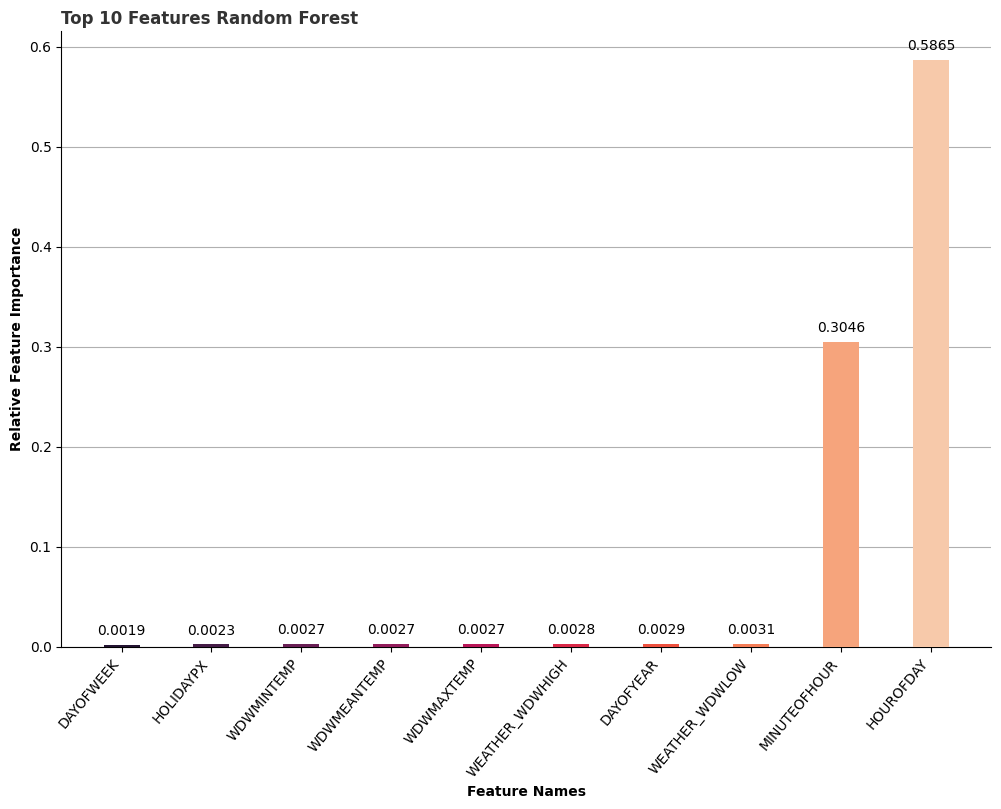

In [178]:
#top 10 features RF
top10_indeces = rf.feature_importances_.argsort()[-10:]
#get according column names
feature_names = list(X_train.columns[top10_indeces])

#Barplot showing relative importance of Top 10 Features
colors = sns.color_palette(palette="rocket", n_colors=len(feature_names))
fig, ax = plt.subplots(figsize=(12,8))
bars = ax.bar(feature_names, rf.feature_importances_[top10_indeces], width= 0.4, color = colors , zorder=3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Relative Feature Importance", weight='bold')
ax.set_xlabel("Feature Names", weight='bold')
ax.set_title("Top 10 Features Random Forest", pad=5, color='#333333', weight='bold', loc='left')
plt.xticks(rotation=50, ha='right')
ax.yaxis.grid(True, color='#b0b0b0', zorder=0)
ax.bar_label(bars, fmt='%.4f', padding=5)


Feature selection by correlation

In [179]:
waittime_corr = waittimes.corr()["SPOSTMIN"]
selected_features = waittime_corr[abs(waittime_corr) > 0.2].sort_values(ascending=False)
selected_features
#low correlation values: no linear relationship among features and target -> but there may be non-linear relationship 

SPOSTMIN                                 1.000000
onehotencoder__x15_Rivers of Light       0.283297
onehotencoder__x13_Happily Ever After    0.269932
AKSHWNGT                                 0.262382
MKFIREWK                                 0.240003
EPFIREWK                                 0.233830
CapacityLostWGT_MK                       0.215586
CapacityLost_MK                          0.214156
AKSHWNT2                                -0.200581
EPFIRET1                                -0.221571
onehotencoder__x14_nan                  -0.221899
onehotencoder__x13_nan                  -0.223440
MKFIRET1                                -0.228862
onehotencoder__x15_nan                  -0.262405
AKSHWNT1                                -0.264071
Name: SPOSTMIN, dtype: float64

Spearman's rank correlation (Spearman's Rho)

-> works for non-linear relations, measures the monotonic relation between a pair of variables 

In [25]:
from scipy import stats

X = waittimes.loc[:, waittimes.columns != "SPOSTMIN"]
y = waittimes['SPOSTMIN']

#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
# applying Spearman correlation to data
rho_matrix = X.corr(method="spearman")
# print(rho_matrix)
# prints the rho coefficient for every feature in correlation with another

In [26]:
# function to get the names of features with a correlation over a chosen threshold
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

# n = chosen threshold
n = 0.85
corr_features = correlation(X, n)
print(str(len(set(corr_features))) + " have a correlation over " + str(n))
#print(corr_features)

98 have a correlation over 0.85


In [28]:
# dropping the features with correlation over the chosen threshold
X.drop(corr_features,axis=1)
#y.drop(corr_features,axis=1)

,onehotencoder__x0_peak,onehotencoder__x0_regular,onehotencoder__x0_value,onehotencoder__x0_nan,onehotencoder__x1_CHRISTMAS,onehotencoder__x1_CHRISTMAS PEAK,onehotencoder__x1_COLUMBUS DAY,onehotencoder__x1_EASTER,onehotencoder__x1_FALL,onehotencoder__x1_HALLOWEEN,...,AKEMHOPEN,AKCLOSEYEST,AKCLOSETOM,WEATHER_WDWHIGH,WEATHER_WDWPRECIP,CapacityLost_EP,MKPRDDAY,AKPRDDAY,HOUROFDAY,MINUTEOFHOUR
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.0,21.0,21.0,70.3,0.12,381963,1,0,9,7
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.0,21.0,21.0,70.3,0.12,381963,1,0,9,11
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.0,21.0,21.0,70.3,0.12,381963,1,0,9,14
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.0,21.0,21.0,70.3,0.12,381963,1,0,9,21
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,8.0,21.0,21.0,70.3,0.12,381963,1,0,9,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70814,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,19.0,19.0,90.7,0.28,381963,0,0,20,33
70815,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,19.0,19.0,90.7,0.28,381963,0,0,20,40
70816,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,19.0,19.0,90.7,0.28,381963,0,0,20,47
70817,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,19.0,19.0,90.7,0.28,381963,0,0,20,54


In [35]:
# applying random forest to selected features
rf = RandomForestRegressor(n_estimators=10, max_depth=50, n_jobs=-1, random_state=42)
rf.fit(X, y)
y_pred = rf.predict(X)

# r2 value is the same as random forest without feature selection
print("RMSE: " + str(round(sqrt(mean_squared_error(y, y_pred)), 2)))
print("R_squared: " + str(round(r2_score(y, y_pred), 2)))

RMSE: 2.76
R_squared: 0.98
